## Imports

In [1]:
!pip3 install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [1]:
import scan_transform
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np

## Image Transformation

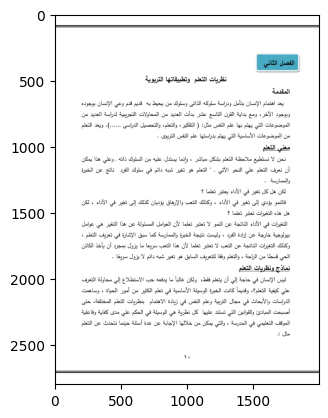

In [2]:
image=scan_transform.preprocess_image('page_15.png')
#Show image
plt.imshow(image)

## Yolo image segmentation Model

###### This model has 2 clases [ images , diagrams].
###### It prepares the image to be an input for the ocr model by masking off any obstacles during the ocr process.
###### Detected classes will be an input for an arabic LLM.

Starting image processing...

0: 512x384 1 image, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 384)


<Figure size 640x480 with 0 Axes>

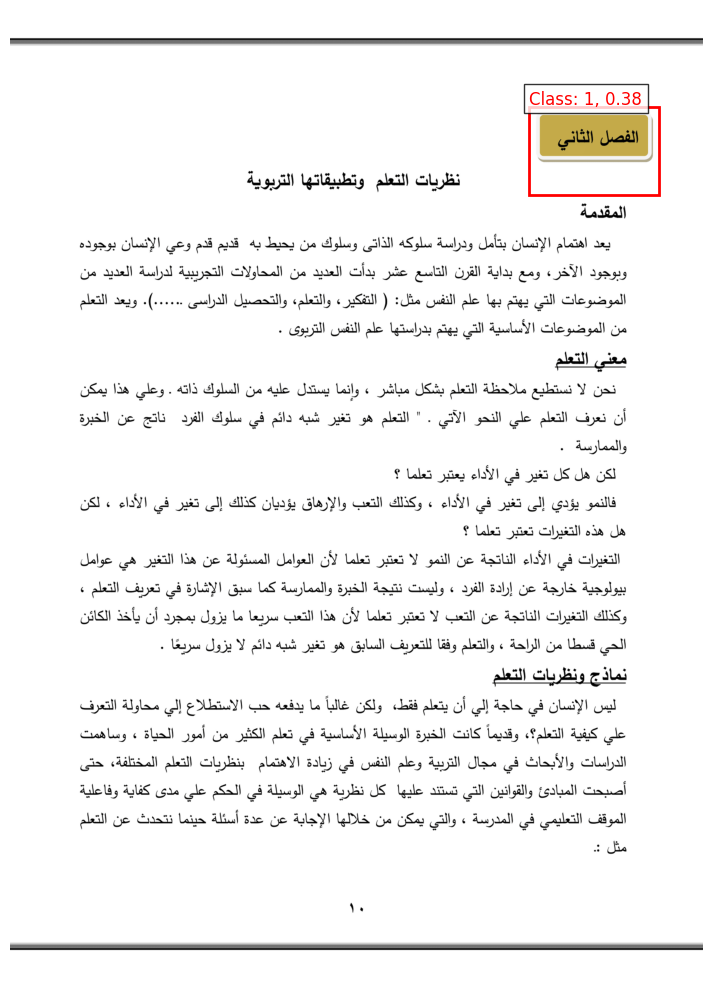

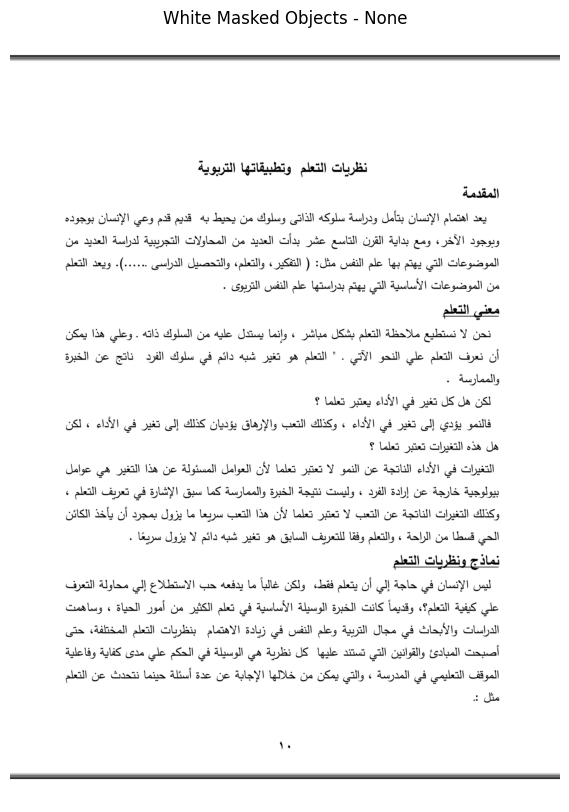

Processing complete.


In [3]:
import segmentation_model
segmented_page=segmentation_model.segment_page(image)

## OCR Model

In [6]:
# !pip3 install "transformers" "qwen_vl_utils" "accelerate>=0.26.0" "PEFT"  "bitsandbytes" -U

In [7]:
# from PIL import Image
# from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
# import torch
# import os
# from qwen_vl_utils import process_vision_info
# from transformers import BitsAndBytesConfig

# model_name = "NAMAA-Space/Qari-OCR-0.2.2.1-VL-2B-Instruct"
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     model_name,
#     device_map="mps"
# )

In [8]:
# image_path = os.path.join( "/content/", f"page_{7}.png")
# image = Image.open(image_path)
# image = image.resize((image.width // 2, image.height // 2))
# prompt = "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate."
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "image": image},
#             {"type": "text", "text": prompt},
#         ],
#     }
# ]
# text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# image_inputs, video_inputs = process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     padding=True,
#     return_tensors="pt",
# )
# inputs = inputs.to("cuda")
# generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
# generated_ids_trimmed = [
#     out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )[0]
# print(output_text)

In [9]:
#multi image and json
# # Directory containing PNG and JSON files
# directory = "/content/"
# output_texts = {}

# # Reduced max_tokens
# max_tokens = 1000  # Reduced from 2000

# for i in range(6, 17):  # For page_6 to page_16
#     image_path = os.path.join(directory, f"page_{i}.png")

#     # Load and resize image
#     image = Image.open(image_path)
#     image = image.resize((image.width // 2, image.height // 2))  # Reduce resolution by half

#     prompt = "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate."

#     messages = [
#         {
#             "role": "user",
#             "content": [
#                 {"type": "image", "image": image},
#                 {"type": "text", "text": prompt},
#             ],
#         }
#     ]

#     # Process the image with your model
#     text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#     image_inputs, video_inputs = process_vision_info(messages)
#     inputs = processor(
#         text=[text],
#         images=image_inputs,
#         videos=video_inputs,
#         padding=True,
#         return_tensors="pt",
#     )
#     inputs = inputs.to("cuda")
#     generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
#     generated_ids_trimmed = [
#         out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
#     ]
#     output_text = processor.batch_decode(
#         generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
#     )[0]
#     print(f"page {i} is processed")
#     # Store the OCR output
#     output_texts[f"page_{i}"] = output_text

In [10]:
# output_text

## PostProcessing

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B")
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-1.5B",
    device_map=device,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    cache_dir="./hcache"
)

Using device: mps


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [41]:
def correct_arabic_text(input_text):
    """Function to correct Arabic text with potential OCR errors"""

    # Create prompt for the model
    prompt = f"""You are an expert in Arabic language. The following text contains OCR mistakes.
Please correct the text while preserving its meaning:

Text with mistakes: {input_text}

Corrected text:"""

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.1,  # Lower temperature for more deterministic output
            top_p=0.85,       # Slightly lower top_p
            do_sample=False,  # Set to False for deterministic generation
            repetition_penalty=1.2  # Discourage repetition
        )

    # Decode the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the corrected text part
    corrected_text = response.split("Corrected text:")[-1].strip()

    return corrected_text

In [42]:

# Prompt templates
correction_prompt = """### Instruction:
أنت مساعد محترف متخصص في تصحيح نصوص اللغة العربية من أخطاء التعرف الضوئي على الحروف (OCR).
قم بتصحيح النص التالي مع مراعاة:
1. تصحيح الأخطاء اللغوية والإملائية
2. التأكد من صحة الأرقام والقيم العددية
3. الحفاظ على المعنى المنطقي للنص
4. تحسين تنسيق النص وترقيمه إذا لزم الأمر

النص الأصلي:
{ocr_text}

[|Human|] أرجو تصحيح هذا النص مع الاحتفاظ بمعناه الأصلي.
[|AI|]
### Response:"""

numbers_verification_prompt = """### Instruction:
أنت مساعد متخصص في التحقق من صحة الأرقام في النصوص العربية.
قم بمراجعة الأرقام والقيم العددية في النص التالي، وتصحيحها إذا كانت غير منطقية مع الحفاظ على المعنى.
إذا لم تكن متأكدًا، اترك الرقم كما هو.

النص:
{ocr_text}

[|Human|] تحقق من صحة الأرقام في هذا النص وتأكد من منطقيتها.
[|AI|]
### Response:"""

semantic_check_prompt = """### Instruction:
أنت مساعد محترف متخصص في تحليل النصوص العربية.
قم بتحليل النص التالي وتحديد ما إذا كان له معنى منطقي ومتماسك.
إذا وجدت أجزاء غير منطقية أو متناقضة، قم بتصحيحها مع الحفاظ على المعنى الأصلي قدر الإمكان.

النص:
{ocr_text}

[|Human|] هل هذا النص له معنى منطقي؟ إذا كان هناك أجزاء غير منطقية، أرجو تصحيحها.
[|AI|]
### Response:"""


In [43]:
output_text='- إجراء عمليات الترتيب والتصنيف باستمرار . ٣- ربط المعطيات بالمطلوب دائما. ؛-حل الألغاز . ٤-القيام بالحساب الذهني يوميا. تطبيقٌ ١: تابع نشرة الأرصاد الجوية لمدة أسبوع ولاحظ العلاقة بين درجة الحرارة ونسبة الرطوبة في الجو . ٢- تطبيقٌ ٢: قم بعمل إحصاء لأعداد الأميين في قريتك أو الحي الذي تسكن فيه ، ثم صنفهم إلى : ذكور وإناث، أطفال وكبار ، عاملين وغير عاملين . Visual Spatial Intelligence ثالثا: الذكاء البصري المكاني يشير إلى قدرة الفرد على الإدراك البصري للعلاقات المكانية من حوله وتطويرها، ومعرفة الأشكال، والأحجام، وإدراك الفرد لبعدي المكان ، بل والبعد الثالث أحيانا من قبل المتميزين في النكاء البصري المكاني، ولذا يتطلب هذا النوع من النكاء حساسية الفرد للألوان والأشكال والمساحات والفراغات وعلاقاتها بالأشياء ، ويتمتع أصحاب الذكاء البصري المكاني بالخصائص التالية :– حب التصوير،وفهم وتفسير الصور والخرائط، والاستمتاع بالفنون البصرية والتعبيرية، وتصميم الصفحات،وتنسيق الألوان، ويتضح هذا النوع من النكاء أكثر لدى المهندسين المعماريين ، ومهندسي الديكور ، ومصممي الأزياء ورجال المرور . ولذا يمكن أن تنمي ذكاءك البصري المكاني من خلال : – ١-حل المتاهات. ٢- تركيب وبناء الأشياء . ٣-تصميم النماذج والمجسمات. تطبيقٌ: إذا أعطيت قطعة أرض فضاء ، ارسم فيها مخططًا للبيت الذي نتمنى أن تعيش فيه. رابغًا: الذكاء الجسمِي الحركي The Bodily kinesthetic intelligence يشير إلى قدرة الفرد على استخدام جسمه ككل أو جزء منه في آداء مميز ، وفي التعبير عن أفكاره وأحاسيسه ومشاعره. يتمتع أصحاب الذكاء الجسمِي الحركي بالخصائص الآتية :– الحركات الجسدية الدقيقة، والتآزر الحركي ،والاشارات ،والتوازن،والمرونة ،والسرعة ، والقوة ،وتمثيل الأدوار ، وسرعة وقوة الحركة،ومرونة الأداء ، ويتضح هذا النوع من النكاء عند لاعبي الكره، والرياضيين عموما ، والعاملين في المعمار'

In [44]:
import re
import unicodedata


In [45]:
def correct_arabic_text(input_text):
    """Function to correct Arabic text with potential OCR errors"""

    # Create prompt for the model - simplified to focus only on correction
    prompt = f"""أنت خبير في اللغة العربية. النص التالي قد يحتوي على أخطاء التعرف الضوئي.
قم بتصحيح النص مع الحفاظ على معناه:

النص الأصلي: {input_text}

النص المصحح:"""

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.2,
            top_p=0.9,
            do_sample=False
        )

    # Decode the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the corrected text part - more precise extraction
    if "النص المصحح:" in response:
        corrected_text = response.split("النص المصحح:")[-1].strip()
    else:
        # Fallback to looking for the text after the input
        corrected_text = response.split(input_text)[-1].strip()
        # Remove any remaining English instructions
        corrected_text = re.sub(r'[A-Za-z:]+', '', corrected_text).strip()

    return corrected_text

corrected = correct_arabic_text(output_text)
corrected

/Users/maryamsaad/Documents/Graduation_Proj/.venv/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/maryamsaad/Documents/Graduation_Proj/.venv/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


'- إجراء عمليات الترتيب والتصنيف باستمرار . ٣- ربط المعطيات بالمطلوب دائما. ؛-حل الألغاز . ٤-القيام بالحساب الذهني يوميا. تطبيقٌ ١: تابع نشرة الأرصاد الجوية لمدة أسبوع ولاحظ العلاقة بين درجة الحرارة ونسبة الرطوبة في الجو . ٢- تطبيقٌ ٢: قم بعمل إحصاء لأعداد الأميين في قريتك أو الحي الذي تسكن فيه ، ثم صنفهم إلى : ذكور وإناث، أطفال وكبار ، عاملين وغير عاملين . Visual Spatial Intelligence ثالثا: الذكاء البصري المكاني يشير إلى قدرة الفرد على الإدراك البصري للعلاقات المكانية من حوله وتطويرها، ومعرفة الأشكال، والأحجام، وإدراك الفرد لبعدي المكان ، بل والبعد الثالث أحيانا من قبل المتميزين في النكاء البصري المكاني، ولذا يتطلب هذا النوع من النكاء حساسية الفرد للألوان والأشكال والمساحات والفراغات وعلاقاتها بالأشياء ، ويتمتع أصحاب الذكاء البصري المكاني بالخصائص التالية :– حب التصوير،وفهم وتفسير الصور والخرائط، والاستمتاع بالفنون البصرية والتعبيرية، وتصميم الصفحات،وتنسيق الألوان، ويتضح هذا النوع من النكاء أكثر لدى المهندسين المعماريين ، ومهندسي الديكور ، ومصممي الأزياء ورجال المرور . ولذا يمكن أن تن

In [46]:
corrected

'- إجراء عمليات الترتيب والتصنيف باستمرار . ٣- ربط المعطيات بالمطلوب دائما. ؛-حل الألغاز . ٤-القيام بالحساب الذهني يوميا. تطبيقٌ ١: تابع نشرة الأرصاد الجوية لمدة أسبوع ولاحظ العلاقة بين درجة الحرارة ونسبة الرطوبة في الجو . ٢- تطبيقٌ ٢: قم بعمل إحصاء لأعداد الأميين في قريتك أو الحي الذي تسكن فيه ، ثم صنفهم إلى : ذكور وإناث، أطفال وكبار ، عاملين وغير عاملين . Visual Spatial Intelligence ثالثا: الذكاء البصري المكاني يشير إلى قدرة الفرد على الإدراك البصري للعلاقات المكانية من حوله وتطويرها، ومعرفة الأشكال، والأحجام، وإدراك الفرد لبعدي المكان ، بل والبعد الثالث أحيانا من قبل المتميزين في النكاء البصري المكاني، ولذا يتطلب هذا النوع من النكاء حساسية الفرد للألوان والأشكال والمساحات والفراغات وعلاقاتها بالأشياء ، ويتمتع أصحاب الذكاء البصري المكاني بالخصائص التالية :– حب التصوير،وفهم وتفسير الصور والخرائط، والاستمتاع بالفنون البصرية والتعبيرية، وتصميم الصفحات،وتنسيق الألوان، ويتضح هذا النوع من النكاء أكثر لدى المهندسين المعماريين ، ومهندسي الديكور ، ومصممي الأزياء ورجال المرور . ولذا يمكن أن تن

In [47]:
output_text

'- إجراء عمليات الترتيب والتصنيف باستمرار . ٣- ربط المعطيات بالمطلوب دائما. ؛-حل الألغاز . ٤-القيام بالحساب الذهني يوميا. تطبيقٌ ١: تابع نشرة الأرصاد الجوية لمدة أسبوع ولاحظ العلاقة بين درجة الحرارة ونسبة الرطوبة في الجو . ٢- تطبيقٌ ٢: قم بعمل إحصاء لأعداد الأميين في قريتك أو الحي الذي تسكن فيه ، ثم صنفهم إلى : ذكور وإناث، أطفال وكبار ، عاملين وغير عاملين . Visual Spatial Intelligence ثالثا: الذكاء البصري المكاني يشير إلى قدرة الفرد على الإدراك البصري للعلاقات المكانية من حوله وتطويرها، ومعرفة الأشكال، والأحجام، وإدراك الفرد لبعدي المكان ، بل والبعد الثالث أحيانا من قبل المتميزين في النكاء البصري المكاني، ولذا يتطلب هذا النوع من النكاء حساسية الفرد للألوان والأشكال والمساحات والفراغات وعلاقاتها بالأشياء ، ويتمتع أصحاب الذكاء البصري المكاني بالخصائص التالية :– حب التصوير،وفهم وتفسير الصور والخرائط، والاستمتاع بالفنون البصرية والتعبيرية، وتصميم الصفحات،وتنسيق الألوان، ويتضح هذا النوع من النكاء أكثر لدى المهندسين المعماريين ، ومهندسي الديكور ، ومصممي الأزياء ورجال المرور . ولذا يمكن أن تن

## Metrics


In [ ]:
from pyarabic import araby
import jiwer
import json
def calculate_ocr_metrics(ocr_text, ground_truth):
    """
    Calculate metrics between OCR output and ground truth
    
    Args:
        ocr_text (str): The OCR output text
        ground_truth (str): The ground truth text
    
    Returns:
        dict: Dictionary containing various metrics
    """
    # Normalize both texts for fair comparison
    ocr_normalized = araby.strip_tashkeel(ocr_text)
    gt_normalized = araby.strip_tashkeel(ground_truth)
    
    # Calculate Word Error Rate
    wer = jiwer.wer(gt_normalized, ocr_normalized)
    
    # Calculate Character Error Rate
    cer = jiwer.cer(gt_normalized, ocr_normalized)
    
    # Calculate Word Information Lost
    wil = jiwer.wil(gt_normalized, ocr_normalized)
    
    # Calculate Match Rate (1 - WER)
    match_rate = 1 - wer
    
    # Calculate word count difference
    ocr_word_count = len(ocr_normalized.split())
    gt_word_count = len(gt_normalized.split())
    word_count_diff = ocr_word_count - gt_word_count
    
    metrics = {
        "WER": wer,
        "CER": cer,
        "WIL": wil,
        "Match Rate": match_rate,
        "OCR Word Count": ocr_word_count,
        "GT Word Count": gt_word_count,
        "Word Count Difference": word_count_diff
    }
    
    return metrics

# Example usage:
ground_truth_text = json.load(open('page_15.json'))
metrics = calculate_ocr_metrics(corrected, ground_truth_text)
print(metrics)